# <mark>PyTorch:</mark> Stochastic-Gradient-Aggregation Dataset Imagewoof

In [1]:
# PyTorch Utils
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.backends.cudnn as cudnn

from torch.utils.data import DataLoader, Subset
from torchvision.transforms import v2 as T
from torchvision import datasets
from torch.optim import lr_scheduler

# MatPlot
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import PercentFormatter

# NumPy
import numpy as np

# Pandas
import pandas as pd

# Other Utils
import os
import cv2
import datetime
from PIL import Image

In [2]:
# Debug CUDA information
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce GTX 1650


In [3]:
# Device usage definition
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

### Functions For Later Use

In [15]:
def process_image(img, transpose=False, numpy=False):
    """
    Preprocess the images to displays them in a plot.

    Parameters:
    - img: The image to preprocess.
    - transpose: Bool value if the img needs to be transposed.
    - numpy: Flag to identify if the image is already in a numpy array.

    Returns:
    - img: The image preprocessed.       
    """        
    if transpose:
        if numpy is False:
            img = img.numpy()
        img = img.transpose((1, 2, 0)) # Transform (X, Y, Z) shape
    img = (img - img.min()) / (img.max() - img.min()) # Clip the image to [0, 255] values
    return img

In [5]:
def preimage(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image

In [6]:
def obj_variance(obj, type=None):
    """
    Display the maximum and minimum value in a given object.

    Parameters:
    - obj: A given object.
    - type: Object type. Can be "tensor" and "numpy".
    """

    if type == "tensor":
        tensor_min = torch.min(obj)
        tensor_max = torch.max(obj)
        
        print("Maximum value:", "{:.2f}".format(tensor_max.item()))
        print("Minimum value:", "{:.2f}".format(tensor_min.item()))
    else:
        numpy_min = "{:.2f}".format(np.max(obj))
        numpy_max = "{:.2f}".format(np.min(obj))
        
        print("Maximum value:", numpy_max)
        print("Minimum value:", numpy_min)

In [7]:
def is_equal(obj1, obj2):
    """
    It compares two Numpy objects and check if they are equal or not.

    Parameters:
    - obj1: A given Numpy object.
    - obj2: A given Numpy object.
    """
    
    np_equal = np.array_equal(obj1, obj2)
    print("Are the images equal?", np_equal)

### Load Imagewoof Dataset

The images are 320x320, with pixel values ranging from 0 to 255. The labels are an array of strings, ranging from 0 to 9. These correspond to the class of clothing the image represents:

| <div style="width:300px">**Label**</div> |  <div style="width:300px">**Class**</div>  |
|:---------------|:---------------|
| n02086240      | Shih-Tzu |
| n02087394      | Rhodesian ridgeback |
| n02088364      | Beagle |
| n02089973      | English foxhound |
| n02093754      | Border terrier |
| n02096294      | Australian terrier |
| n02099601      | Golden retriever |
| n02105641      | Old English sheepdog |
| n02111889      | Samoyed |
| n02115641      | Dingo |

<br>

In [8]:
# Define the batch size
batch_size = 8

In [9]:
# Define the directory where your dataset is located
data_dir = 'Datasets/Imagewoof'

In [10]:
# Define the transformations you want to apply to the images
data_transforms = {
    'train': T.Compose([
        T.ToImage(), # Convert to tensor, because the image comes has PIL
        T.Resize(size=(224, 224)),
        T.RandomHorizontalFlip(),
        T.RandomGrayscale(p=0.1),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        T.ToImage(), # Convert to tensor, because the image comes has PIL
        T.Resize(size=(224, 224)),
        T.CenterCrop(224),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
# Create datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

In [12]:
# Create dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

### Define New Classes With the Correct Dog Breeds

In [13]:
# Correct dog breeds
dog_breeds = [
    'Shih-Tzu', 'Rhodesian Ridgeback', 'Beagle', 'English Foxhound', 'Border Terrier',
    'Australian Terrier', 'Golden Retriever', 'Old English Sheepdog', 'Samoyed', 'Dingo'
]

# Assing the dog breeds to the class names
class_names = dog_breeds

### Iterating and Visualising the Dataset

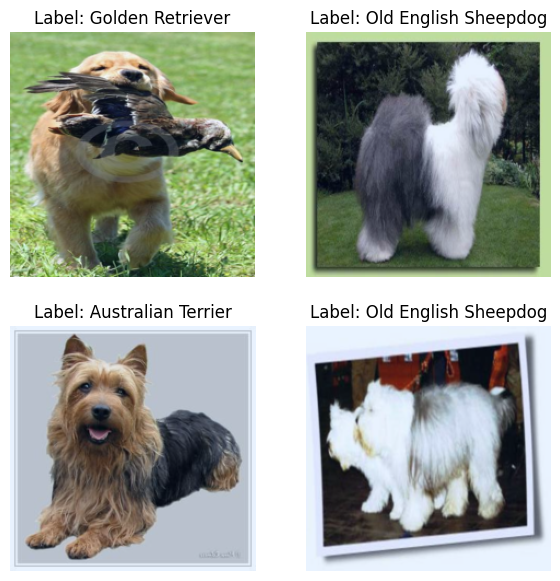

In [16]:
# Get a batch of images and labels
imgs, labels = next(iter(dataloaders['train']))

# Plot the images
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for i, ax in enumerate(axes.flat):
    # Convert the tensor to numpy array and transpose the dimensions if necessary
    img_np = imgs[i].numpy().transpose((1, 2, 0)) if isinstance(imgs, torch.Tensor) else imgs[i]
    img_np = process_image(img_np)
    
    ax.imshow(img_np)
    ax.set_title(f'Label: {class_names[labels[i]]}')
    ax.axis('off')

plt.show()

### Adversarial Dataset Development

In [17]:
uap = torch.load('./SGA/UAP/SGA/Delta_5000_20_Epochs_8_Batch.pth')

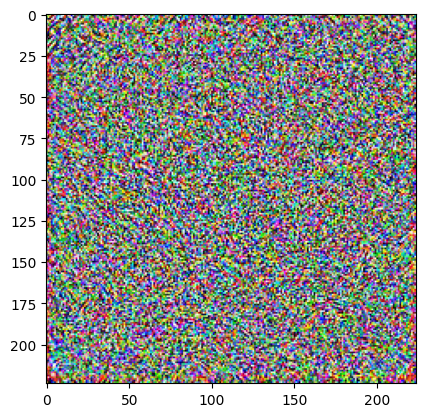

In [18]:
uap_processed = process_image(uap, transpose=True, numpy=False)
plt.imshow(uap_processed)

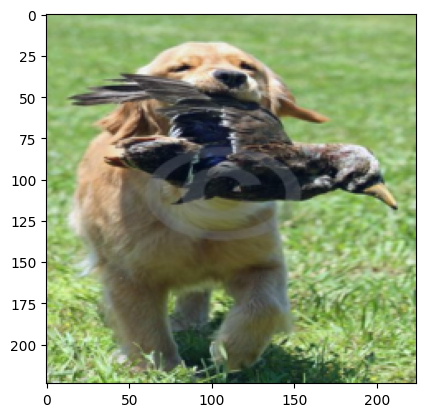

In [19]:
img = process_image(imgs[0], transpose=True, numpy=False)
plt.imshow(img)

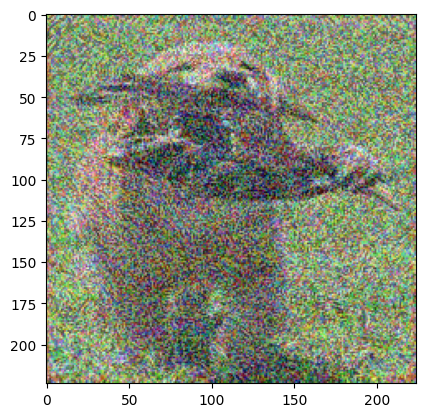

In [20]:
k = img + uap_processed
k_processed = process_image(k, transpose=False, numpy=True)
plt.imshow(k_processed)
plt.imsave(f"./Adversarial-Images/TestUAP.jpg", k_processed)

In [ ]:
# Create an empty list to store adversarial images
adversarial_dataset = []
real_dataset = []
real_labels = []

for i in range(3):
    # Load your dataset
    imgs, labels = next(iter(dataloaders['val']))
    
    # Convert PyTorch tensor to numpy array if necessary
    imgs_np = imgs.numpy()
    labels_np = labels.numpy()
    
    uap = uap.cpu()
    
    # Iterate through the dataset
    for img in imgs_np:
        adversarial_img = img + uap.numpy()
        adversarial_dataset.append(adversarial_img)
        real_dataset.append(img)
        
    for lbl in labels_np:
        real_labels.append(lbl)

# Convert the list of adversarial images back to a PyTorch tensor
adversarial_dataset = torch.Tensor(adversarial_dataset)

In [ ]:
image_names = []
for i in range(len(adversarial_dataset)):
    img_adv = adversarial_dataset[i].numpy().transpose((1, 2, 0))
    img_adv = preimage(img_adv)
    
    # Image nomenclature: XX-YY.jpg 
    # XX - Image number
    # YY - Image real class
    name = f"{i:03}-{real_labels[i]:02}.jpg"
    image_names.append(name)
    plt.imsave(f"./Adversarial-Images/{name}", img_adv)
    print(f"[SAVED] Adversarial Image: {i:03}; Real Label: {real_labels[i]:02}; Real Class: {class_names[real_labels[i]]}")
    
    # plt.imshow(img_adv)

In [ ]:
# plt.title(f'Predicted: {class_names[real_labels[image_index]]}')
# img_real = process_image(real_dataset[image_index].transpose((1, 2, 0)), False)
# plt.imshow(img_real)

In [ ]:
# np_equal = np.array_equal(img_adv, img_real)
# print("Are the images equal?", np_equal)

### <mark>Load Model!</mark>

In [21]:
model = torch.jit.load('./Models/ModelVGG16.pt') # Load
model.eval()

RecursiveScriptModule(
  original_name=VGG
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Conv2d)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=MaxPool2d)
    (5): RecursiveScriptModule(original_name=Conv2d)
    (6): RecursiveScriptModule(original_name=ReLU)
    (7): RecursiveScriptModule(original_name=Conv2d)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=MaxPool2d)
    (10): RecursiveScriptModule(original_name=Conv2d)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=Conv2d)
    (13): RecursiveScriptModule(original_name=ReLU)
    (14): RecursiveScriptModule(original_name=Conv2d)
    (15): RecursiveScriptModule(original_name=ReLU)
    (16): RecursiveScriptModule(original_name

### Inference on Adversarial Dataset

In [ ]:
def visualise_model_predictions(model, image_index, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)
    
    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        plt.figsize=(10, 10)
        plt.axis('off')
        plt.title(f'Predicted: {class_names[preds[0]]} ({class_names[real_labels[image_index]]})')
        img = process_image(img.cpu().data[0], transpose=True, numpy=False)
        plt.imshow(img)
        plt.show()
        
        model.train(mode=was_training)

In [ ]:
for i in range(len(adversarial_dataset)):
    visualise_model_predictions(
        model,
        i,
        img_path=f'./Adversarial-Images/{image_names[i]}'
    )

In [ ]:
visualise_model_predictions(
    model,
    0,
    img_path=f'./Adversarial-Images/TestUAP.jpg'
)

---

### Testing... 

In [24]:
val_dataset = datasets.ImageFolder('Datasets/Imagewoof/val', data_transforms['val'])
num_images = 3000

# Random subset if not using the full 3500 validation set
if num_images < 3500:
    np.random.seed(0)
    sample_indices = np.random.permutation(range(3500))[:num_images]
    val_dataset = Subset(val_dataset, sample_indices)

loader_val = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=4)

In [ ]:
# Get a batch of images and labels
imgs, labels = next(iter(loader_val))

In [ ]:
uap = torch.load('./SGA/UAP/SGA/Delta_5000_20_Epochs_8_Batch.pth')
uap = uap.unsqueeze(0).repeat([batch_size, 1, 1, 1]).to(device)

with torch.no_grad():
    x_val = imgs.to(device)
    y_ori = torch.nn.functional.softmax(model(x_val), dim=1)
    perturbed = torch.clamp((x_val + uap), 0, 1)
    # perturbed = x_val + uap

In [ ]:
p = perturbed[0].cpu()
img_p = process_image(p, transpose=True, numpy=False)
plt.title(f'Real Class: {class_names[labels[0]]}')
plt.imshow(img_p)
plt.imsave(f"./Adversarial-Images/000-00.jpg", img_p)

In [ ]:
z = imgs[0].cpu()
img_z = process_image(z, transpose=True, numpy=False)
plt.title(f'Real Class: {class_names[labels[0]]}')
plt.imshow(img_z)

In [ ]:
is_equal(img_z, img_p)

In [ ]:
uap = torch.load('./SGA/UAP/SGA/Delta_5000_20_Epochs_8_Batch.pth')

In [ ]:
uap

In [ ]:
uap_repeated = uap.unsqueeze(0).repeat([batch_size, 1, 1, 1]).to(device)

In [ ]:
uap_repeated

In [ ]:
uap_processed = process_image(uap, transpose=True, numpy=False)
plt.imshow(uap_processed)

---

In [22]:
num_images = 3000

In [25]:
model.eval()

uap = torch.load('./SGA/UAP/SGA/Delta_5000_20_Epochs_8_Batch.pth')
uap = uap.unsqueeze(0).repeat([batch_size, 1, 1, 1]).to(device)

probs, labels, y_out = [], [], []

with torch.no_grad():
    for i, data in enumerate(loader_val):
        x_val = data[0].to(device)
        y_val = data[1].to(device)

        y_ori = torch.nn.functional.softmax(model(x_val), dim=1)
        perturbed = torch.clamp((x_val + uap), 0, 1) # Clamp to [0, 1]
        out = torch.nn.functional.softmax(model(perturbed), dim=1)

        probs.append(out.cpu().numpy())
        labels.append(y_val.cpu())
        y_out.append(y_ori.cpu().numpy())

In [44]:
x_val[0]

torch.Size([8, 10])

In [48]:
obj_variance(x_val[3], type="tensor")

Maximum value: 2.64
Minimum value: -1.91


In [35]:
# Convert batches to single numpy arrays
probs = np.array([p for l in probs for p in l])
labels = np.array([t for l in labels for t in l])
y_out = np.array([s for l in y_out for s in l])

In [ ]:
# Predictions of all the validation dataset
probs[0].argmax()

In [ ]:
probs_argmax_array = []
for i in enumerate(probs):
    probs_argmax_array.append(probs[i[0]].argmax())

In [ ]:
probs_argmax_array[5]

In [ ]:
# Real labels of all the validation dataset
labels[5]

In [ ]:
equal = 0
for i in range(num_images):
    if probs_argmax_array[i] == labels[i]:
        equal += 1

In [ ]:
fooling_rate = (equal*100)/num_images
fooling_rate

In [ ]:
top = np.argpartition(-probs, 9, axis=1)[:,:9]
top_probs = probs[np.arange(probs.shape[0])[:, None], top].astype(np.float32)

In [ ]:
top

In [ ]:
outputs = top[range(len(top)), np.argmax(top_probs, axis = 1)]

In [ ]:
y_top = np.argpartition(-y_out, 9, axis=1)[:, :9]
y_top_probs = y_out[np.arange(y_out.shape[0])[:, None], y_top].astype(np.float32)
y_outputs = y_top[range(len(y_top)), np.argmax(y_top_probs, axis=1)]

In [ ]:
print('[INFO] Fooling ratio:', (1-sum(y_outputs == outputs) / len(labels))*100)

---

In [ ]:
perturbed

In [ ]:
for i in range(len(out)):
    print(out[i].argmax())

In [ ]:
for i in range(len(y_ori)):
    print(y_ori[i].argmax())

---

In [ ]:
p = torch.load('./SGA/UAP/SGA/Perturbed.pt', map_location=lambda storage, loc: storage.cuda(0))

In [ ]:
len(p)*batch_size

In [ ]:
p_example = p[0][0].cpu()

In [ ]:
p_255 = p_example * 255
p_255 = p_255.to(torch.uint8)

In [ ]:
obj_variance(p_255, type="tensor")

In [ ]:
p_img = process_image(p_255, transpose=True, numpy=False)
plt.title(f'Real Class: {class_names[labels[0]]}')
plt.imshow(p_img)

In [ ]:
print(f'Data type of p_img: {p_img.dtype}')
print(f'Min value in p_img: {p_img.min()}')
print(f'Max value in p_img: {p_img.max()}')

In [ ]:
for i in range(len(p[0])):
    p_cpu = p[0][i].cpu()
    p_img = process_image(p_cpu, transpose=True, numpy=False)
    name = f"{i:03}.jpg"
    plt.imsave(f"./Adversarial-Images/{name}", p_img)
    print(f"[SAVED] Adversarial Image: {i:03}")

In [ ]:
def rgb_img_analysis(image_path, val_unic=False):
    """
    Analyze properties of an image.

    Parameters:
        image_path (str): path to the image file
        val_unic (bool): whether to print unique pixel values (default: False)
        save_figure (bool): whether to save the plotted figure to a file (default: False)
        figure_path (str): path to save the figure (required if save_figure is True)

    Raises:
        FileNotFoundError: if the file at image_path does not exist or cannot be opened
        ValueError: if figure_path is not specified when save_figure is True
    """
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"No such file: '{image_path}'")

    with open(image_path, "rb") as f:
        img_bytes = f.read()
    img = cv2.imdecode(np.frombuffer(img_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)[..., ::-1]

    if img is None:
        raise ValueError(f"Failed to read image at '{image_path}'")

    print(f"Image with {len(img_bytes)} bytes")
    print(f"Image type: {type(img)}")
    print(f"Image dimensions (height, width, channels): {img.shape}")
    print(f"Pixel value range: [{img.min()}, {img.max()}]")

    if val_unic:
        print(f"Unique pixel values: {np.unique(img)}")

    fig = plt.figure(figsize=(20, 12), constrained_layout=False)
    gs = gridspec.GridSpec(nrows=2, ncols=3)

    # RGB image
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title(f"Image\n'{os.path.basename(image_path)}'")
    ax1.imshow(img)
    ax2 = fig.add_subplot(gs[0, 1:])
    color = ("b", "g", "r")
    
    for channel, col in enumerate(color):
        histr = cv2.calcHist([img], [channel], None, [256], [0, 256])
        ax2.plot(histr, color=col)
        ax2.set_xlim([0, 256])
        ax2.legend(["Blue", "Green", "Red"])

    
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.set_title('RED Channel') 
    ax3.set_ylabel('Width {}'.format(img.shape[1])) 
    ax3.set_xlabel('Height {}'.format(img.shape[0])) 
    ax3.imshow(img[ : , : , 0], cmap = 'gray')

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_title('GREEN Channel') 
    ax4.set_ylabel('Width {}'.format(img.shape[1])) 
    ax4.set_xlabel('Height {}'.format(img.shape[0])) 
    ax4.imshow(img[ : , : , 1], cmap = 'gray')

    ax5 = fig.add_subplot(gs[1, 2])
    ax5.set_title('BLUE Channel')
    ax5.set_ylabel('Width {}'.format(img.shape[1])) 
    ax5.set_xlabel('Height {}'.format(img.shape[0])) 
    ax5.imshow(img[ : , : , 2], cmap = 'gray')

In [ ]:
rgb_img_analysis('./Adversarial-Images/005.jpg')